# Tutorial 4: Self-supervised learning
Self-supervised learning means that we can train our network given only raw inputs, with no labels whatsoever.

## SimCLR
SimCLR shown that even a very simple implementation of contrastive learning can work given enough data. Main findings are
- Augmentations are important
- MLP between the representation and the contrastive loss significanlty boosts the performance
- Contrastive cross-entropy is sensitive to normalization and temperature
- Longer training and larger batches has stronger effect on contrastive learning
- Larger and wider networks are as important as in supervised learning

### Augmentations

In [1]:
from torchvision.datasets.utils import download_url
import os
import tarfile
import hashlib

# https://github.com/fastai/imagenette
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz'
dataset_filename = dataset_url.split('/')[-1]
dataset_foldername = dataset_filename.split('.')[0]
data_path = './data'
dataset_filepath = os.path.join(data_path,dataset_filename)
dataset_folderpath = os.path.join(data_path,dataset_foldername)

os.makedirs(data_path, exist_ok=True)

download = False
if not os.path.exists(dataset_filepath):
    download = True
else:
    md5_hash = hashlib.md5()


    file = open(dataset_filepath, "rb")

    content = file.read()

    md5_hash.update(content)


    digest = md5_hash.hexdigest()
    if digest != 'fe2fc210e6bb7c5664d602c3cd71e612':
        download = True
if download:
    download_url(dataset_url, data_path)

with tarfile.open(dataset_filepath, 'r:gz') as tar:
    tar.extractall(path=data_path)

In [2]:
class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]

    def __repr__(self):
        format_string = self.__class__.__name__ + '(\n\t'
        format_string += self.base_transform.__repr__().replace('\n', '\n\t')
        format_string += '\n)'
        return format_string

In [3]:
import torchvision
import torch
from torchvision.transforms import transforms

size  = 224
ks = (int(0.1 * size) // 2) * 2 + 1 # should be odd
__imagenet_stats = {'mean': [0.485, 0.456, 0.406],
                    'std': [0.229, 0.224, 0.225]}

train_transform = TwoCropsTransform(transforms.Compose([transforms.RandomResizedCrop(scale=(0.2, 1), size=size),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
                                      transforms.RandomGrayscale(p=0.2),
                                      transforms.GaussianBlur(kernel_size=ks),
                                      transforms.ToTensor(),
                                      transforms.Normalize(**__imagenet_stats)]))

dataset_train = torchvision.datasets.ImageFolder(os.path.join(dataset_folderpath,'train'), train_transform)
#valid_ds = ImageFolder('./data/imagenette-160/val', valid_tfms)

batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=batch_size,
        num_workers=8,
        drop_last=True,
        shuffle=True,
)


In [4]:
import numpy as np

def get_numpy_samples(inputs):
        mean = torch.as_tensor(__imagenet_stats['mean'], dtype=inputs.dtype, device=inputs.device)
        std = torch.as_tensor(__imagenet_stats['std'], dtype=inputs.dtype, device=inputs.device)
        inputs = inputs * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)
        inputs = inputs.numpy()
        inputs = np.transpose(inputs, (0,2,3,1))
        return inputs


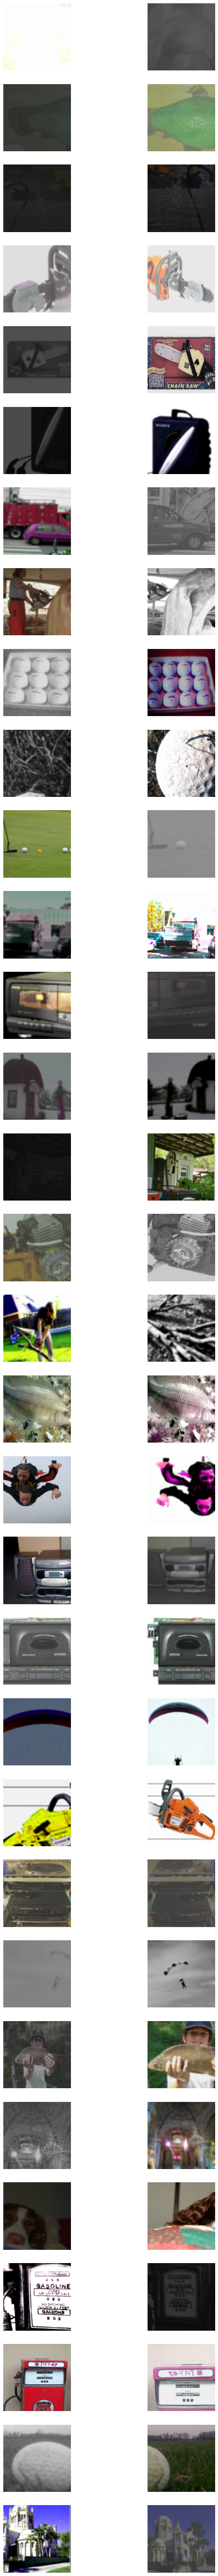

In [5]:
import matplotlib.pyplot as plt
     
fig, axes = plt.subplots(nrows=batch_size, ncols=2, figsize=(10,100))
for (input1, input2), _ in train_dataloader:
    np_inputs1, np_inputs2 = get_numpy_samples(input1), get_numpy_samples(input2)
    for row in range(batch_size):
        axes[row, 0].axis("off")
        axes[row, 0].imshow(np_inputs1[row])
        axes[row, 1].axis("off")
        axes[row, 1].imshow(np_inputs2[row])
    break
plt.show()

### Contrastive loss
![](figures/contrast.png)

In [6]:
from torch.nn import functional as F
def contrastive_loss(z1, z2, tau=0.2):
    N = z1.shape[0]
    logits = torch.mm(z1, z2.t())  # [N, N] pairs
    labels = torch.arange(N).cuda()  # positives are in diagonal
    loss = F.cross_entropy(logits / tau, labels)
    return 2 * tau * loss

In [7]:
def get_projection(in_dim, h_dim=4096, out_dim=256, use_bn=True):
    if use_bn:
        return nn.Sequential(nn.Linear(in_dim, h_dim), nn.BatchNorm1d(h_dim), nn.ReLU(inplace=True),
                             nn.Linear(h_dim, h_dim), nn.BatchNorm1d(h_dim), nn.ReLU(inplace=True),
                             nn.Linear(h_dim, out_dim))
    else:
        return nn.Sequential(nn.Linear(in_dim, h_dim), nn.ReLU(inplace=True),
                             nn.Linear(h_dim, h_dim), nn.ReLU(inplace=True),
                             nn.Linear(h_dim, out_dim))

In [8]:
from torch import nn

class SimCLR(nn.Module):
    def __init__(self, base_network, h_dim=4096, out_dim=256, use_bn=False):
        super().__init__()
        self.base_network = base_network
        self.projector = get_projection(self.base_network.fc.in_features, h_dim=h_dim, out_dim=out_dim, use_bn=use_bn)
    
    def forward(self, x1, x2):
        h1, h2 = self.base_network.forward_features(x1), self.base_network.forward_features(x2)
        z1, z2 = self.projector(h1), self.projector(h2)
        return h1, h2, z1, z2

In [9]:
def simclr_iteration(model, x1, x2):
    _, _, z1, z2 = model(x1, x2)
    z1, z2 = F.normalize(z1, dim=1), F.normalize(z2, dim=1)
    return contrastive_loss(z1, z2)

In [10]:
# from torchvision
import torch
from torch import Tensor
import torch.nn as nn
from torchvision.models.utils import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward_features(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        return x

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.forward_features(x)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)
    
def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

In [11]:
base_model = resnet18(num_classes=10)
model = SimCLR(base_model)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
from tqdm.notebook  import tqdm

epochs = 10
print_step = 10
for epoch in range(1, epochs + 1):
    total_loss = 0
    for batch_idx, ((x1, x2), _) in enumerate(tqdm(train_dataloader)):
        x1, x2 = x1.cuda(), x2.cuda()
        loss = simclr_iteration(model, x1, x2)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        if batch_idx % print_step == 0:
            tqdm.write('Loss {:.4f}'.format(loss.item()))
    print('Epoch {}: mean loss={:.4f}'.format(epoch, total_loss/len(train_dataloader)))

  0%|          | 0/295 [00:00<?, ?it/s]

Loss 1.3807
Loss 1.3437
Loss 1.3655
Loss 1.3860
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Epoch 1: mean loss=1.3858


  0%|          | 0/295 [00:00<?, ?it/s]

Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
Loss 1.3863
